In [38]:
import torch
import torchvision
import os
import torch.nn as nn
import torch.nn.functional as F
import torch_dct
import numpy as np
from torch.autograd import Variable
import copy
from torch.autograd.gradcheck import zero_gradients

In [39]:
class LeNet(nn.Module):
    def __init__(self, ch=1, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(ch, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [40]:
class TransformLayer(torch.nn.Module):

    def __init__(self, mean, std):
        super().__init__()
        self.mean = torch.nn.Parameter(mean, requires_grad=False)
        self.std = torch.nn.Parameter(std, requires_grad=False)

    def forward(self, x):
        return x.sub(self.mean).div(self.std)

In [41]:
BATCH_SIZE = 128
trainset = torchvision.datasets.MNIST(root='./Datasets', download=True, train=True, transform=torchvision.transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./Datasets', download=True, train=False, transform=torchvision.transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)
mean = torch.tensor([0.1307])[None, :, None, None]
std = torch.tensor([0.3081])[None, :, None, None]
trans = TransformLayer(mean=mean, std=std)
model = LeNet()
model_dir = 'Models/Pretrained/MNIST/LeNet/model.pth'
model.load_state_dict(torch.load(model_dir))

<All keys matched successfully>

In [42]:
def generate_subspace_list(subspace_dim, dim, subspace_step, channels):
    """
    subspace_dim = 8 用于定义子空间的维度, 即8*8的子空间矩阵
    dim = 28 图像的维度, 即28*28的图像矩阵
    subspace_step = 1 子空间步长
    channels = 1 通道数
    """
    subspace_list = []
    # 初始化一个空的子空间列表（subspace_list）用于存储生成的子空间矩阵
    
    idx_i = 0
    idx_j = 0
    # 设置两个索引变量idx_i和idx_j的初始值为0，用于迭代遍历图像的行和列。

    while (idx_i + subspace_dim - 1 <= dim - 1) and (idx_j + subspace_dim - 1 <= dim - 1):
        # 这个循环用于生成不重叠的子空间，确保子空间的维度不超过图像的边界

        S = torch.zeros((subspace_dim, subspace_dim, dim, dim), dtype=torch.float32)
        #在循环中，首先创建一个空的四维张量S，其形状为(subspace_dim, subspace_dim, dim, dim)
        # 这个张量将用于存储子空间中的离散余弦变换系数。
        """
        对于8*8的子空间, 遍历每个子空间的位置即64个位置, 每个位置都创建一个28*28的矩阵
        且对于这64个28*28的矩阵, 每个矩阵中只有一个元素为1, 其余全为0
        该过程其实是在子空间中的每个位置创建一个单位脉冲信号。
        单位脉冲信号是一个具有单个非零值(通常为1)的向量或矩阵,其他位置都为零。 
        """
        for i in range(subspace_dim):
            for j in range(subspace_dim):
                dirac = torch.zeros((dim, dim), dtype=torch.float32)
                dirac[idx_i + i, idx_j + j] = 1.
                """
                dirac表示单位脉冲信号 用于表示子空间中的一个基础元素
                dirac是一个28*28的矩阵 且只有一个位置为1 其余为0
                idx_i 与 idx_j 相等  
                在一个循环内 从(idx_i, idx_j)开始 (idx_i+8, idx_j+8)结束
                """
                
                S[i, j] = torch_dct.idct_2d(dirac, norm='ortho')
                #使用torch_dct.idct_2d函数对单位脉冲信号进行二维离散余弦变换
                #对一个 28x28 的图像进行二维离散余弦变换后的离散余弦变换矩阵的大小为 28x28
                # 离散余弦变换矩阵中的每个元素表示不同频率成分的权重或系数
        

        Sp = S.view(subspace_dim * subspace_dim, dim * dim)
        Sp = Sp.t() # 进行转置操作
        subspace_list.append(Sp)
        # 每一个sp是 (784,64)维度的矩阵
        idx_i += subspace_step
        idx_j += subspace_step
    # 对于28*28的矩阵，划分8*8的非重叠子空间，从0开始，每次行和列移动1格，最终得到21个8*8的非重叠子空间
    return subspace_list




In [43]:
def subspace_deepfool(im, model, trans, num_classes=10, overshoot=0.02, max_iter=100, Sp=None):
    """ 
    输入图像'im'
    模型'model'
    数据转换函数'trans'以及其他可选参数作为输入
    """
    image = copy.deepcopy(im)
    input_shape = image.size()

    f_image = model(trans(Variable(image, requires_grad=True))).view((-1,))
    I = f_image.argsort(descending=True)
    I = I[0:num_classes]
    label_orig = I[0]
    # 得到模型对该图像的预测标签

    pert_image = copy.deepcopy(image)
    # 创建一个图像副本用于存储扰动后的图像

    r = torch.zeros(input_shape)
    # 创建一个全零张量r，用于存储最终生成的对抗扰动

    label_pert = label_orig
    loop_i = 0
    # 初始化扰动后的标签为原始标签，设置迭代计数器为0

    while label_pert == label_orig and loop_i < max_iter:
        # 进入迭代循环，直到扰动后的标签不等于原始标签或达到最大迭代次数为止
        x = Variable(pert_image, requires_grad=True)
        fs = model(trans(x))

        pert = torch.Tensor([np.inf])[0]
        # 创建一个初始扰动pert，初始化为正无穷大。
        w = torch.zeros(input_shape)
        # 创建一个与输入图像相同大小的全零张量w

        fs[0, I[0]].backward(retain_graph=True)
        # 对模型输出fs的第一个标签（原始标签）进行反向传播，计算关于输入x的梯度
        grad_orig = copy.deepcopy(x.grad.data)
        # 将计算得到的梯度x.grad.data进行深拷贝，存储在grad_orig中

        for k in range(1, num_classes):
            zero_gradients(x)
            # 将输入x的梯度清零

            fs[0, I[k]].backward(retain_graph=True)
            # 对模型输出fs的第k个标签进行反向传播 计算关于输入x的梯度。
            cur_grad = copy.deepcopy(x.grad.data)
            # 将计算得到的梯度x.grad.data进行深拷贝 存储在cur_grad中

            w_k = cur_grad - grad_orig
            # 计算权重差值w_k 即当前梯度与原始梯度的差值。
            f_k = (fs[0, I[k]] - fs[0, I[0]]).data
            # 计算输出差值f_k 即当前标签的输出值与原始标签的输出值之差。
            if Sp is None:
                pert_k = torch.abs(f_k) / w_k.norm()
            else:
                pert_k = torch.abs(f_k) / torch.matmul(Sp.t(), w_k.view([-1, 1])).norm()
                # Sp.t() 是对Sp矩阵求转置，得到了真正的64个二维离散余弦变换矩阵
                # w_k.view([-1, 1]) 表示将权重差值 w_k 进行形状变换，变为一个(784,1)的矩阵
                # 两者相乘 得到(64,1)的矩阵，这样784维的特征转换为64维特征，计算在64维空间上的对抗扰动
            if pert_k < pert:
                pert = pert_k + 0.
                w = w_k + 0.

        if Sp is not None:
            w = torch.matmul(Sp, torch.matmul(Sp.t(), w.view([-1, 1]))).reshape(w.shape)

        r_i = torch.clamp(pert, min=1e-4) * w / w.norm()
        r = r + r_i

        pert_image = pert_image + r_i

        label_pert = torch.argmax(model(trans(Variable(image + (1 + overshoot) * r, requires_grad=False))).data).item()

        loop_i += 1

    return (1 + overshoot) * r, loop_i, label_orig, label_pert, image + (1 + overshoot) * r


In [44]:
def compute_margin_distribution(model, trans, dataloader, subspace_list, path=None, proc_fun=None):
    margins = []
    # 初始化一个空的列表 margins 用于存储边界值

    print('Measuring margin distribution...')
    for s, Sp in enumerate(subspace_list):
        sp_margin = []
        # 创建一个空的列表 sp_margin 用于存储当前子空间下的边界值

        # 共21个子空间，在这21个子空间下计算边界值
        for inputs, targets in dataloader:
            adv_perts = torch.zeros_like(inputs)
            for n, im in enumerate(inputs):
                # im 是每个(28, 28)的图像
                adv_perts[n], _, _, _, _ = subspace_deepfool(im, model, trans, Sp=Sp)
                # 输入的数据 im为(1,28,28)的图像，Sp为(784,64)的子空间
                
            sp_margin.append(adv_perts.cpu().view([-1, np.prod(inputs.shape[1:])]).norm(dim=[1]))
        
        sp_margin = torch.cat(sp_margin)
        margins.append(sp_margin.numpy())
        print('Subspace %d:\tMedian margin: %5.5f' % (s, np.median(sp_margin)))
    
    np.save(path, margins)
    return np.array(margins)

In [47]:
SUBSPACE_DIM = 8
DIM = 28
SUBSPACE_STEP = 1

subspace_list = generate_subspace_list(SUBSPACE_DIM, DIM, SUBSPACE_STEP, channels=1)
# 该子空间列表共21个元素,每个元素是一个784x64的二维张量
# 每个元素是一个8*8的子空间，且每个8*8的子空间中的每个位置由一个28*28的经二维离散余弦变换的单位脉冲信号表示
# 即每个位置原本是一个28*28的one-hot编码的单位脉冲信号，经二维离散余弦变换得到单位脉冲在频域的表示，即离散余弦变换系数。
# 这些系数反映了单位脉冲在不同频率上的分量，对应于图像中不同频率的特征。
# 而28*28的图像经二维离散余弦变换后得到的是28*28的离散余弦变换矩阵，离散余弦变换将图像从时域转换到频域
# 相当于得到28*28共784个频率，对应每个频率的振幅强度
# 所以究竟有多少个子空间？

# 随机选择100个样本
NUM_SAMPLES_EVAL = 100
indices = np.random.choice(len(testset), NUM_SAMPLES_EVAL, replace=False)
eval_dataset = torch.utils.data.Subset(testset, indices[:NUM_SAMPLES_EVAL])
eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=BATCH_SIZE,shuffle=False)

In [46]:
margins = compute_margin_distribution(model, trans, eval_loader, subspace_list)

Measuring margin distribution...


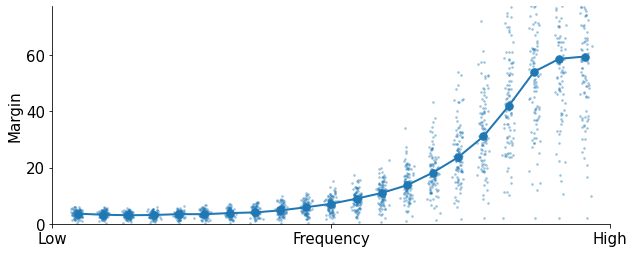

In [33]:
from graphics import swarmplot
swarmplot(margins, color='tab:blue')